## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

import seaborn as sns
# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(columns=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
vars_num = [ var for var in data.columns if data[var].dtypes !='O'] 

vars_cat = [ var for var in data.columns if data[var].dtypes =='O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [11]:
# first in numerical variables

vers_with_na_n = [var for var in data.columns if data[var].isnull().sum() !=0 and data[var].dtypes != 'O']

data[vers_with_na_n].isnull().mean()

age     0.200917
fare    0.000764
dtype: float64

In [12]:
# now in categorical variables

vers_with_na_c = [var for var in data.columns if data[var].isnull().sum() >0 and data[var].dtypes == 'O']

data[vers_with_na_c].isnull().mean()

cabin       0.774637
embarked    0.001528
dtype: float64

### Determine cardinality of categorical variables

In [13]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

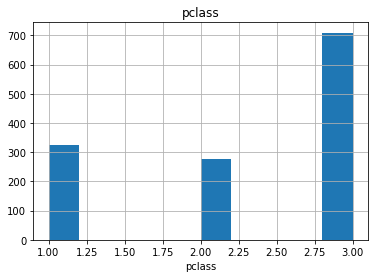

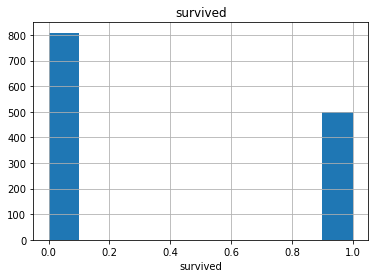

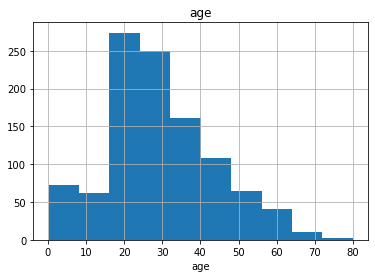

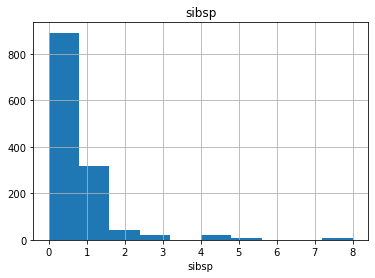

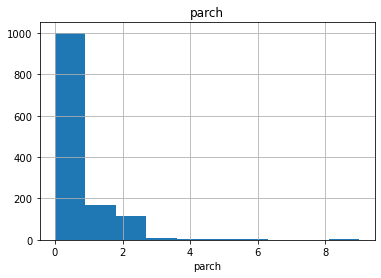

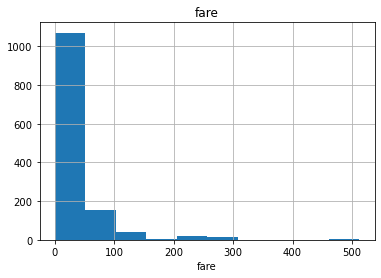

In [14]:
def analyse_num(df,vars):
    df = df.copy()
    for var in vars:
        df[var].hist()
        plt.title(var)
        plt.xlabel(var)
        plt.show()
        

analyse_num(data,vars_num)   
    

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [16]:
def extract_letter(var):
    try:
        return var[0]
    except:
        return np.nan

X_train['cabin'] = X_train['cabin'].apply(lambda x : extract_letter(x) )
X_test['cabin'] = X_test['cabin'].apply(lambda x : extract_letter(x) )
    

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [17]:
#filing missing data for numarical variables
var_num_train = [var for var in X_train.columns if X_train[var].dtype != 'O']
for var in var_num_train:
    
    #calculating median
    median_val = data[var].median()
      
#     creating binary missing indecator
    X_train[var+'_NA'] = np.where(X_train[var].isnull(),0,1)
    X_test[var+'_NA'] =  np.where(X_test[var].isnull(),0,1)
    
#     replacing null values with median
    X_train[var].fillna(median_val,inplace =True)
    X_test[var].fillna(median_val,inplace =True)
    
X_train[vers_with_na_n].isnull().sum()

age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [18]:
X_train[vers_with_na_c] = X_train[vers_with_na_c].fillna('missing')
X_test[vers_with_na_c] = X_test[vers_with_na_c].fillna('missing')

In [19]:
#check that if we have missing values in engineered variables in train
X_train[vers_with_na_c].isnull().sum()

cabin       0
embarked    0
dtype: int64

In [20]:
#check that if we have missing values in engineered variables in test
X_test[vers_with_na_c].isnull().sum()

cabin       0
embarked    0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [21]:
var_cat_train = [var for var in X_train.columns if X_train[var].dtype == 'O']

In [22]:
def find_freq_variable(train,var,rare_per):

    train['survived'] = y_train

    temp = train[train['survived']==1].groupby(var)['survived'].count()/len(train['survived'])
    
    return temp[temp > rare_per].index

for var in var_cat_train:
    #Find frequent categories
    freq_cat = find_freq_variable(X_train,var,0.01)
    
    #Replace Rare Categoris with Rare
    X_train[var] = np.where(X_train[var].isin(freq_cat),X_train[var],'Rare')
    X_test[var] = np.where(X_test[var].isin(freq_cat),X_test[var],'Rare')

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [23]:
def replace_cat(train,test,var,target):
    train[target] = y_train
    
    #Order categoris for survived passengers from lowest to highest
    orderd_labels = train[train[target]==1].groupby(var)[target].count().sort_values().index
    
    #Create an orderd dictionary with numerical values
    ordinal_labels = {k: i for i,k in enumerate(orderd_labels,0)}
    
    #Using dictionary mapping the categorical variables
    train[var] = train[var].map(ordinal_labels)
    test[var] = test[var].map(ordinal_labels)
    try:
        train.drop(columns=[target],axis=1, inplace=True)
        test.drop(columns=[target],axis=1, inplace=True)
    except:
        pass

In [24]:
for var in var_cat_train:
    replace_cat(X_train,X_test,var,'survived')
    

In [25]:
X_train.isnull().sum()

pclass       0
sex          0
age          0
sibsp        0
parch        0
fare         0
cabin        0
embarked     0
title        0
pclass_NA    0
age_NA       0
sibsp_NA     0
parch_NA     0
fare_NA      0
dtype: int64

In [26]:
X_test.isnull().sum()

pclass       0
sex          0
age          0
sibsp        0
parch        0
fare         0
cabin        0
embarked     0
title        0
pclass_NA    0
age_NA       0
sibsp_NA     0
parch_NA     0
fare_NA      0
dtype: int64

### Scale the variables

- Use the standard scaler from Scikit-learn

In [27]:
# getting all variables

all_variable = [var for var in X_train.columns]

In [28]:
#Define Scallaer

scaler = StandardScaler()

#Fit the scaler to the train set
scaler.fit(X_train[all_variable])

#transfrom the test and train set
X_train[all_variable] = scaler.transform(X_train[all_variable])
X_test[all_variable] = scaler.transform(X_test[all_variable])



In [29]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,pclass_NA,age_NA,sibsp_NA,parch_NA,fare_NA
1118,0.835808,-0.761042,-0.370162,-0.478911,-0.455423,-0.504782,0.464000,0.587208,-0.490829,0.0,0.494921,0.0,0.0,0.03092
44,-1.542157,1.313987,0.904029,-0.478911,-0.455423,1.971555,-1.799079,-0.930834,1.623979,0.0,0.494921,0.0,0.0,0.03092
1072,0.835808,-0.761042,-0.131251,-0.478911,-0.455423,-0.508533,0.464000,-2.448876,-0.490829,0.0,-2.020526,0.0,0.0,0.03092
1130,0.835808,1.313987,-0.927621,-0.478911,-0.455423,-0.507717,0.464000,0.587208,1.623979,0.0,0.494921,0.0,0.0,0.03092
574,-0.353174,-0.761042,-0.051614,0.434422,-0.455423,-0.248980,0.464000,0.587208,-0.490829,0.0,0.494921,0.0,0.0,0.03092


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [30]:
#Set up the model

lr_model = LogisticRegression( penalty='l2',tol=0.0005, random_state=0)

#Train the model

lr_model.fit(X_train,y_train)


LogisticRegression(random_state=0, tol=0.0005)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [31]:
#Importing required Libraries 
from sklearn.metrics import classification_report, auc,roc_curve

#Getting train Prediction
train_pred = lr_model.predict(X_train)

#Train classification Report
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       647
           1       0.75      0.71      0.73       400

    accuracy                           0.80      1047
   macro avg       0.79      0.78      0.79      1047
weighted avg       0.80      0.80      0.80      1047



In [32]:
#Test Prediction
test_pred = lr_model.predict(X_test)

#Test Classification Report
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       162
           1       0.79      0.64      0.71       100

    accuracy                           0.80       262
   macro avg       0.80      0.77      0.78       262
weighted avg       0.80      0.80      0.79       262



In [33]:
#Getting True Positive Rate and False Positive Rate for Train 
fpr_trn, tpr_trn, thresholds_trn = roc_curve(y_train,train_pred)

#Getting True Positive Rate and False Positive Rate for Test 
fpr, tpr, thresholds = roc_curve(y_test,test_pred)

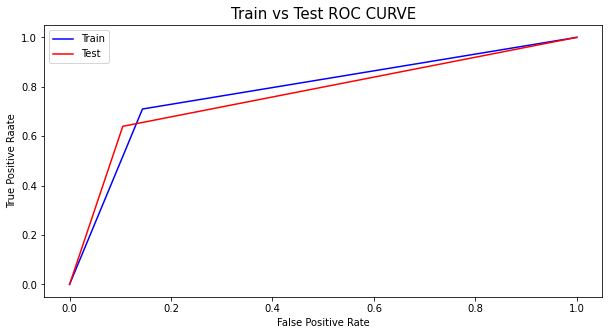

Train AUC:	 0.7831298299845442
Test AUC:	 0.7675308641975309


In [34]:
#Ploting ROC Curve for Train
plt.figure(figsize=(10,5))
p1, = plt.plot(fpr_trn, tpr_trn,color='blue')
p2, = plt.plot(fpr, tpr, color='red')
plt.ylabel('True Positive Raate')
plt.xlabel("False Positive Rate")
plt.legend([p1,p2],['Train','Test'])
plt.title('Train vs Test ROC CURVE', size=15)

plt.show()

print('Train AUC:\t',auc(fpr_trn, tpr_trn))
print('Test AUC:\t',auc(fpr, tpr))

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**